# kSZ Effect

In this notebook we show how to use the `glasz` package to model the kSZ Effect profile as 
measured from [Schaan et al 2021](https://arxiv.org/abs/2009.05557). 

In [28]:
# preamble
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pyccl as ccl
from init_halo_model import (  # halo model
    a_arr,
    bM,
    cM_relation,
    cosmo,
    hmc,
    hmd,
    k_arr,
    r_arr,
)

import glasz

# CMASS PARAMETERS
z_lens = 0.55  # Mean z for CMASS
a_sf = 1 / (1 + z_lens)

# constituent fractions
fb = cosmo["Omega_b"] / cosmo["Omega_m"]  # Baryon fraction
fc = cosmo["Omega_c"] / cosmo["Omega_m"]  # CDM fraction

# define 2-halo term
xi_mm_2h = glasz.profiles.calc_xi_mm_2h(
    cosmo, hmd, cM_relation, hmc, k_arr, a_arr, r_arr, a_sf
)

## Create Profiles

We first create the gas (baryon) profile which we will then use to create the $T_{\rm kSZ}$ signal. For more information on how to do this, visit the `profiles` notebook.

In [29]:
# Halo Mass
M_halo = 3e13

# 2-halo Amplitude
A_2h = 1.0

# GNFW Parameters
alpha = 1.0
beta = 3.0
gamma = 0.2
x_c = 0.5

Rb = 10 * (hmd.get_radius(cosmo, M_halo, a_sf) / a_sf)

# COMPUTE GNFW AMPLITUDE
prof_nfw = ccl.halos.HaloProfileNFW(
    mass_def=hmd, concentration=cM_relation, truncated=False, fourier_analytic=True
)

prof_baryons = glasz.profiles.HaloProfileGNFW(
    hmd,
    rho0=1.0,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    x_c=x_c,
)

prof_baryons.normalize(cosmo, Rb, M_halo, a_sf, prof_nfw)


# COMPUTE 3D DENSITY PROFILES
def rho_2h(r):
    return (
        xi_mm_2h(r)
        * bM(cosmo, M_halo, a_sf)
        * ccl.rho_x(cosmo, a_sf, "matter", is_comoving=True)
        * A_2h
    )


prof_baryons.rho_2h = rho_2h  # add 2-halo term to baryon profile

prof_matter = glasz.profiles.MatterProfile(
    mass_def=hmd, concentration=cM_relation, rho_2h=rho_2h
)

From here we use the `kSZ` subpackage of `glasz` to compute the $T_{\rm kSZ}$ signal.

In [30]:
# COMPUTE kSZ PROFILE
theta = np.geomspace(0.5, 6.5, 20)


def rho_gas_3D(r):
    """
    We need to be careful about comoving units here. The kSZ code assumes
    that the density profile is in physical units. The array which it will
    be feeding into this function is in physical units r = aχ. The CCL
    profile assumes comoving units so we need to convert the input to
    comoving units before passing it to the profile. Then we need to convert
    the density profile back into physical units before returning it by
    dividing by the scale factor a^3.
    """
    return (fb * prof_baryons.real(cosmo, r / a_sf, M_halo, a_sf)) / a_sf**3


T_kSZ_150 = glasz.kSZ.create_T_kSZ_profile(theta, z_lens, rho_gas_3D, "f150", cosmo)
T_kSZ_090 = glasz.kSZ.create_T_kSZ_profile(theta, z_lens, rho_gas_3D, "f090", cosmo)

We can plot the difference between the 2 frequency bands for a given profile below.

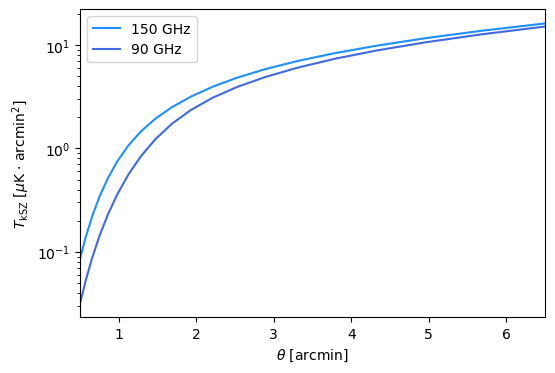

In [31]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.semilogy(
    theta, T_kSZ_150 * glasz.constants.sr2sqarcmin, label="150 GHz", color="dodgerblue"
)
ax.semilogy(
    theta, T_kSZ_090 * glasz.constants.sr2sqarcmin, label="90 GHz", color="royalblue"
)

ax.set_xlabel(r"$\theta$ [arcmin]")
ax.set_ylabel(r"$T_{\rm kSZ}$ [$\mu$K $\cdot$ arcmin$^2$]")
ax.legend()
ax.set_xlim(0.5, 6.5)
plt.show()